Title: Source Reconstruct of Spherical NFW Lens

Date: 08/03/2020

Obj: Using the MGE formalism to reconstruct que the original source galaxy deflected by a spherical NFW mass model

In [1]:

import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('SphericalNFW MGE.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solMass/u.pc**2)                        #Surface Density in M_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Mass_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                 #Total mass per gaussian component in M_sun




#Defining inputs for the integral below
i = np.deg2rad(90)*u.rad                                       #Inclination angle in rad
M0 = Mass_mge                                                  #Mass per gaussian component in M_sun
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad
M0.sum()

<Quantity 1.76749207e+12 solMass>

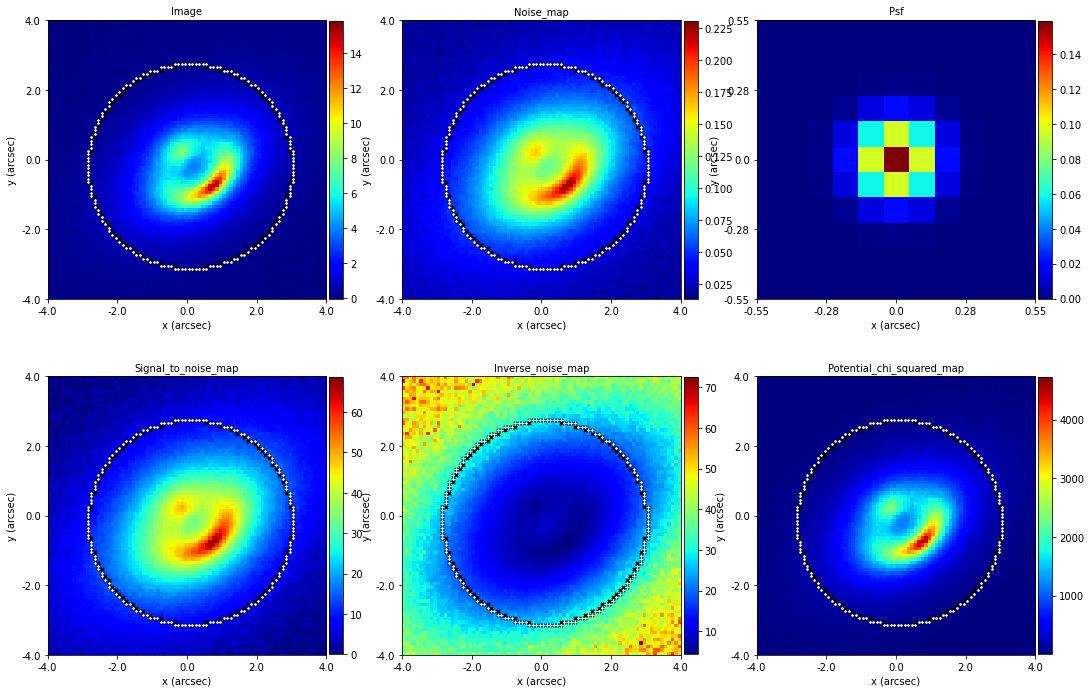

In [10]:
#Reading simulated data

dataset_type = "Different Integrations/Serial"
dataset_name = "Data"
dataset_path = f"{workspace_path}/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageNFW.fits",
    noise_map_path=f"{dataset_path}/NoiseNFW.fits",
    psf_path=f"{dataset_path}/PSFNFW.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1,radius=3. ,centre=(-0.2, 0.1)
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True)
)


__Defining the MGE mass model for the lens galaxy and performing the ray tracing__

In [11]:
#Definindo o perfil MGE e realizando o ray tracing
time = clock()

mass_profile = al.mp.MGE(centre=(0.0, 0.0))
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]



print("Tempo para gerar o perfil MGE, realizar o ray tracing e criar o source plane grid", (clock() - time))

Tempo para gerar o perfil MGE, realizar o ray tracing e criar o source plane grid 56.51470151400008


In [31]:
masked_imaging.grid.shape

(2828, 2)

In [12]:
#Galaxy information
print(lens_galaxy)

Redshift: 0.035
Mass Profiles:
MGE
centre: (0.0, 0.0)
M: [9.82065047e-09 5.28693608e-08 2.82155381e-07 1.48414851e-06
 7.69826047e-06 3.94132430e-05 1.99405547e-04 9.98294055e-04
 4.95247149e-03 2.43811879e-02 1.19281080e-01 5.80713489e-01
 2.81694015e+00 1.36310134e+01 6.58682212e+01 3.18149606e+02
 1.53725791e+03 7.43536592e+03 3.60152660e+04 1.74726664e+05
 8.48797145e+05 4.12525923e+06 2.00228511e+07 9.67298846e+07
 4.62222981e+08 2.16057959e+09 9.72705676e+09 4.25019164e+10
 2.03227025e+11 1.50929133e+12]
sigma: [5.23908572e-15 1.22755115e-14 2.84855672e-14 6.56158956e-14
 1.50070730e-13 3.40915793e-13 7.69632507e-13 1.72770676e-12
 3.85921677e-12 8.58374743e-12 1.90243603e-11 4.20434594e-11
 9.27100476e-11 2.04108693e-10 4.48897714e-10 9.86745648e-10
 2.16884842e-09 4.76849889e-09 1.04902481e-08 2.30946185e-08
 5.08807110e-08 1.12151900e-07 2.47177165e-07 5.44052095e-07
 1.19329567e-06 2.59805010e-06 5.58309496e-06 1.18374726e-05
 2.57768841e-05 6.99768432e-05]
q: [1. 1. 1. 1. 1.

In [13]:
time = clock()
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
print(clock() - time)

time = clock()
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]
print(clock() - time)

0.0004886380002062651
55.95521131499936


__Rectangular Inversion__

Tempo para fazer o mapeamento com uma grid retangular 0.15311852200011344


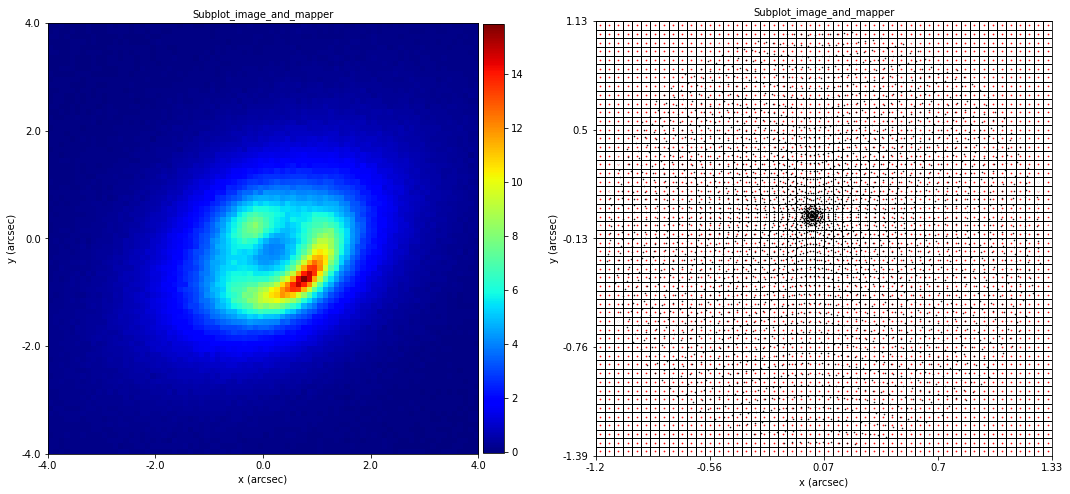

In [14]:
#Agora fazemos o mapper com uma grid retangular
time = clock()

rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

print('Tempo para fazer o mapeamento com uma grid retangular', (clock() - time))

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)



In [16]:
#Agora realizamos a inversão com grid regular
time = clock()

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=3.0),
)

print('Tempo para realizar a inversão:', (clock() - time))

Tempo para realizar a inversão: 0.46872381399953156


In [32]:
#Defining some output configs

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/Different Integrations/Serial/Image Output/Rectangular Reconstruction/',
                                          filename='Rectangular Inversion Plots',
                                          format='png'),        
                              )

plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/Different Integrations/Serial/Image Output/Rectangular Reconstruction/',
                                          format='png'),         
                          )

include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )


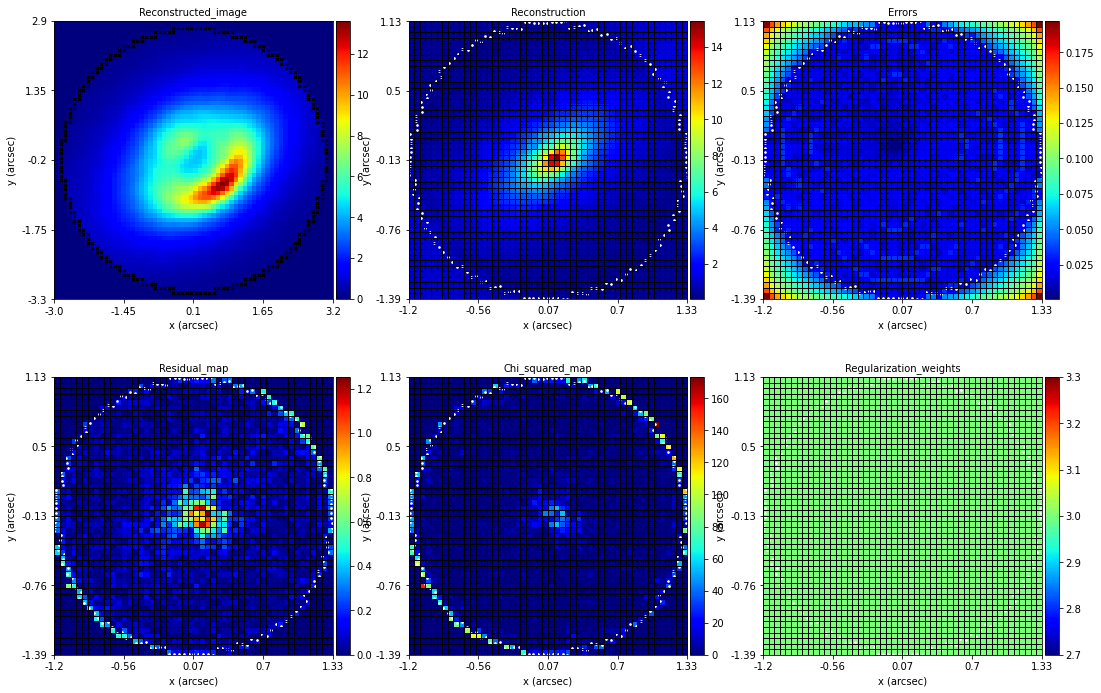

In [33]:
#Ploting Results
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                 sub_plotter=sub_plotter
                                )
 
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                )

In [19]:
#Save image results
aplt.Inversion.individuals(inversion=inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                               )


Agora vamos realizar a inversão com um grid adaptativa
-------------------

In [20]:
#Here we define an usulfull function
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):
    mass_profile = al.mp.MGE(centre=(0.0, 0.0))
    mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
    lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


__Inversion with Constante Voronoi__

In [34]:
#Agora vamos 

time = clock()

source_magnification = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(50, 50)),
    regularization=al.reg.Constant(coefficient=1),
)

print("Tempo para gerar a fonte como uma grid Voronoi Adaptativa", (clock()-time))

time = clock()

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

print("Tempo para realizar a inversão numa grid adaptativa", (clock() - time))

Tempo para gerar a sonte como uma grid Voronoi Adaptativa 0.0002181370000471361
Tempo para realizar a inversão numa grid adaptativa 97.57395667699893


In [22]:
sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/Different Integrations/Serial/Image Output/ConstVoronoi/',
                                          filename='Constant Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/Different Integrations/Serial/Image Output/ConstVoronoi/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

In [23]:
#Save images
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    sub_plotter=sub_plotter, 
                                    )



aplt.Inversion.individuals(inversion=fit.inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                           plot_regularization_weight_map=True,
                               )

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


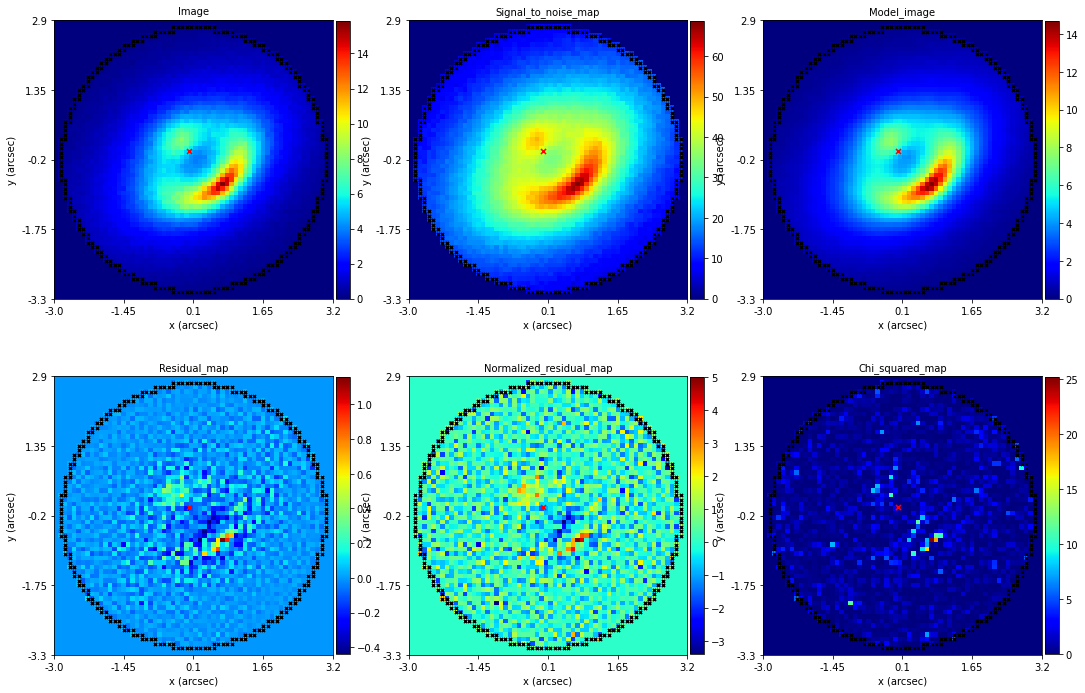

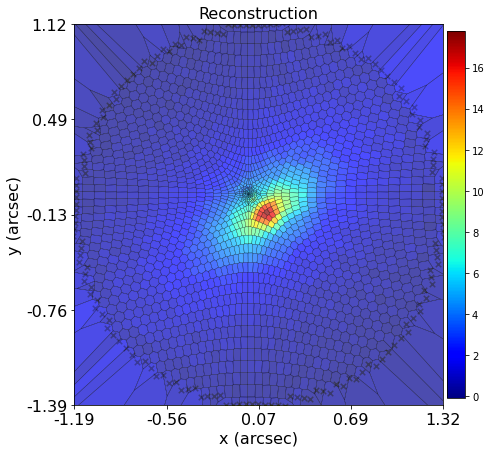

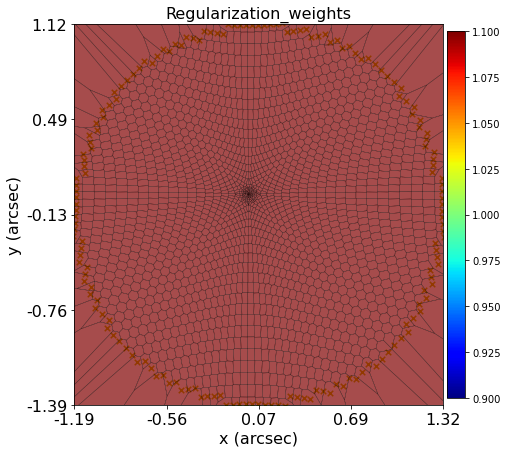

Evidence using adaptive _Regularization_=  1549.0979868194727


In [29]:
#Plot images
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=False, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)
frist_log = fit.log_evidence